In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import statsmodels.formula.api as smf

from prediction_ML_pipeline import train_and_evaluate_model, add_date_ticker
from order_imbalance import order_imbalance, combined_order_imbalance, diagnostic_plots, lm_results, iceberg_order_imbalance

In [2]:
MSFT_m = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_message_10.csv", header=None)
MSFT_ob = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)

In [3]:
SPY_m2 = pd.read_csv("./data/SPY/SPY_2019-01-02_24900000_57900000_message_10.csv", header=None)
SPY_m3 = pd.read_csv("./data/SPY/SPY_2019-01-03_24900000_57900000_message_10.csv", header=None)
# SPY_m4 = pd.read_csv("./data/SPY/SPY_2019-01-04_24900000_57900000_message_10.csv", header=None)

SPY_ob2 = pd.read_csv("./data/SPY/SPY_2019-01-02_24900000_57900000_orderbook_10.csv", header=None)
SPY_ob3 = pd.read_csv("./data/SPY/SPY_2019-01-03_24900000_57900000_orderbook_10.csv", header=None)
# SPY_ob4 = pd.read_csv("./data/SPY/SPY_2019-01-04_24900000_57900000_orderbook_10.csv", header=None)

pred_date = ['2019-01-02', '2019-01-03']

SPY_m_lst = []
MSFT_m_lst = []
for df, date in zip([SPY_m2, SPY_m3], pred_date):
    df_adj = add_date_ticker(df, date, 'SPY')
    SPY_m_lst.append(df_adj)


for df, date in zip([MSFT_m], ['2012-06-21']):
    df_adj = add_date_ticker(df, date, 'MSFT')
    MSFT_m_lst.append(df_adj)


SPY_m = pd.concat(SPY_m_lst)
SPY_ob = pd.concat([SPY_ob2, SPY_ob3])


MSFT_m = pd.concat(MSFT_m_lst)

In [4]:
df_m_labelled_lst = [MSFT_m]
df_ob_labelled_lst = [MSFT_ob]
tickers_train = ['MSFT']
df_m_predict_lst = [SPY_m]
df_ob_predict_lst = [SPY_ob]
tickers_pred = ['SPY']
train_date = ['2012-06-21']
pred_date = ['2019-01-02', '2019-01-03']

In [5]:
classifier = RandomForestClassifier()
param_grid = {
    'n_estimators': [50],
    # 'max_depth': [None, 10, 20, 30],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
}


results = train_and_evaluate_model(classifier, param_grid, df_ob_labelled_lst, 
                                   df_m_labelled_lst, tickers_train,
                                   df_ob_predict_lst, df_m_predict_lst, tickers_pred)
df_labelled_dict, df_predict_dict, features_dict, prediction_dict, best_classifier = results

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
[CV] END ....................................n_estimators=50; total time=   0.1s
Best parameters found:  {'n_estimators': 50}
Best accuracy found:  0.9139064302109146
Accuracy on the train data: 1.0
Accuracy on the test data: 0.9311334289813487


In [9]:
order_imbalance_SPY = iceberg_order_imbalance(df_predict_dict['SPY'][0], prediction_dict['pred'], delta='30S')

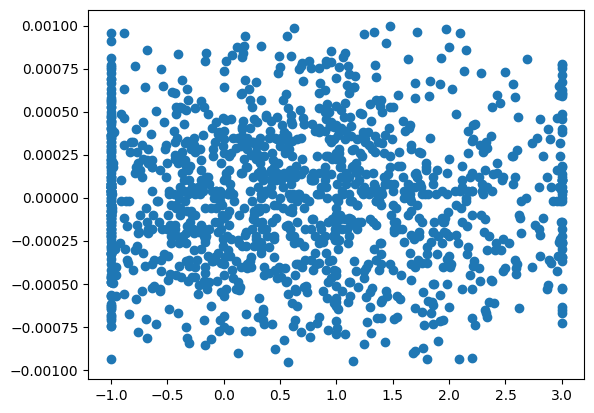

In [10]:
plt.scatter(order_imbalance_SPY['order_imbalance_hid'][:-1], order_imbalance_SPY['log_ret'][1:])

In [11]:
lm = smf.ols(formula="""fut_log_ret ~ order_imbalance_vis + +order_imbalance_ib+ order_imbalance_hid""", 
             data=order_imbalance_SPY).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fut_log_ret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.366
Date:                Sun, 21 Jul 2024   Prob (F-statistic):              0.252
Time:                        23:02:26   Log-Likelihood:                 8287.1
No. Observations:                1295   AIC:                        -1.657e+04
Df Residuals:                    1291   BIC:                        -1.655e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            4.574e-06   1.31e-05      0.350      0.726   -2.11e-05    3.02e-05
order_imbalance_vis  5.017e-05   3.16e-05      1.587      0.113   -1.19e-05       0.000
order_imbalance_ib  -2.241e-06   4.15e-05     -0.054      0.957   -8.36e-05    7.91e-05
order_imbalance_hid -1.362e-05   9.79e-06     -1.392      0.164   -3.28e-05    5.58e-06
==============================================================================
Omnibus:                       15.491   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.113
Skew:                           0.052   Prob(JB):                      0.00637
Kurtosis:                       2.580   Cond. No.                         5.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
df_results = lm_results(df_predict_dict['SPY'][0], prediction_dict['pred'], ['5S', '15S', '30S', '1min', '5min'],
                        order_type='vis', predictive=False)
df_results

,timeframe,params,tvalues
0,5S,0.000141,30.795310
1,15S,0.000348,21.336371
2,30S,0.000632,16.418836
3,1min,0.001198,12.637806
4,5min,0.005323,7.378693
